# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
* 		/datasets/geo_data_0.csv. Скачать датасет
* 		/datasets/geo_data_1.csv. Скачать датасет
* 		/datasets/geo_data_2.csv. Скачать датасет
* 		id — уникальный идентификатор скважины;
* 		f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* 		product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

**Загрузим библиотеки**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

**Загрузим датасеты для регионов и посмотрим на их содержимое**

In [2]:
data_region0 = pd.read_csv('/datasets/geo_data_0.csv')
data_region1 = pd.read_csv('/datasets/geo_data_1.csv')
data_region2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
data_region0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data_region0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_region1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
data_region1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data_region2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
data_region2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Данные впорядке:**

 - **Отсутствуют пропуски**
 - **Все названия колонок в одинаковом регистре**
 - **Тип данных соответствует содержимому**

In [9]:
print('Количество явных дубликатов в датасете для региона 0 - ', data_region0.duplicated().sum())
print('Количество явных дубликатов в датасете для региона 1 - ', data_region1.duplicated().sum())
print('Количество явных дубликатов в датасете для региона 2 - ', data_region2.duplicated().sum())

Количество явных дубликатов в датасете для региона 0 -  0
Количество явных дубликатов в датасете для региона 1 -  0
Количество явных дубликатов в датасете для региона 2 -  0


**Проверим, есть в датасетах неявные дубликаты**

In [10]:
print('Всего id в data_region0 -', len(data_region0['id']),'из них уникальных id - ', data_region0['id'].nunique())
print('Всего id в data_region1 -', len(data_region1['id']),'из них уникальных id - ', data_region1['id'].nunique())
print('Всего id в data_region2 -', len(data_region2['id']),'из них уникальных id - ', data_region2['id'].nunique())

Всего id в data_region0 - 100000 из них уникальных id -  99990
Всего id в data_region1 - 100000 из них уникальных id -  99996
Всего id в data_region2 - 100000 из них уникальных id -  99996


**Похоже, что не которые id вышек повторяются. Возможно, для некоторых вышек проводился повторный анализ. Количество дубликатов по отношению к общему количеству id невелико, а установить между двумя одинаковыми id единственное верное не представляется возможным, так как значение признаков не разглашается. Поэтому, удалим id и их дубликаты.**

In [11]:
duplicated_id_region0 = data_region0[data_region0['id'].duplicated()]['id']
duplicated_id_region1 = data_region1[data_region1['id'].duplicated()]['id']
duplicated_id_region2 = data_region2[data_region0['id'].duplicated()]['id']
data_region0 = data_region0.query('id not in @duplicated_id_region0')
data_region1 = data_region1.query('id not in @duplicated_id_region1')
data_region2 = data_region2.query('id not in @duplicated_id_region2')

In [12]:
print('Размер data_region0 после удаления дубликатов - ', data_region0.shape)
print('Размер data_region1 после удаления дубликатов - ', data_region1.shape)
print('Размер data_region2 после удаления дубликатов - ', data_region2.shape)

Размер data_region0 после удаления дубликатов -  (99980, 5)
Размер data_region1 после удаления дубликатов -  (99992, 5)
Размер data_region2 после удаления дубликатов -  (99990, 5)


**Признак id является не информативным для дальнейшего обучения модели, поэтому удалим содержащую его колонку.**

In [13]:
data_region0 = data_region0.drop('id', axis=1)
data_region1 = data_region1.drop('id', axis=1)
data_region2 = data_region2.drop('id', axis=1)

In [14]:
print('Размер data_region0 после удаления колонки с id - ', data_region0.shape)
print('Размер data_region1 после удаления колонки с id - ', data_region1.shape)
print('Размер data_region2 после удаления колонки с id - ', data_region2.shape)

Размер data_region0 после удаления колонки с id -  (99980, 4)
Размер data_region1 после удаления колонки с id -  (99992, 4)
Размер data_region2 после удаления колонки с id -  (99990, 4)


**Посмотрим на распределение цифровых значений для всех датасетов.**

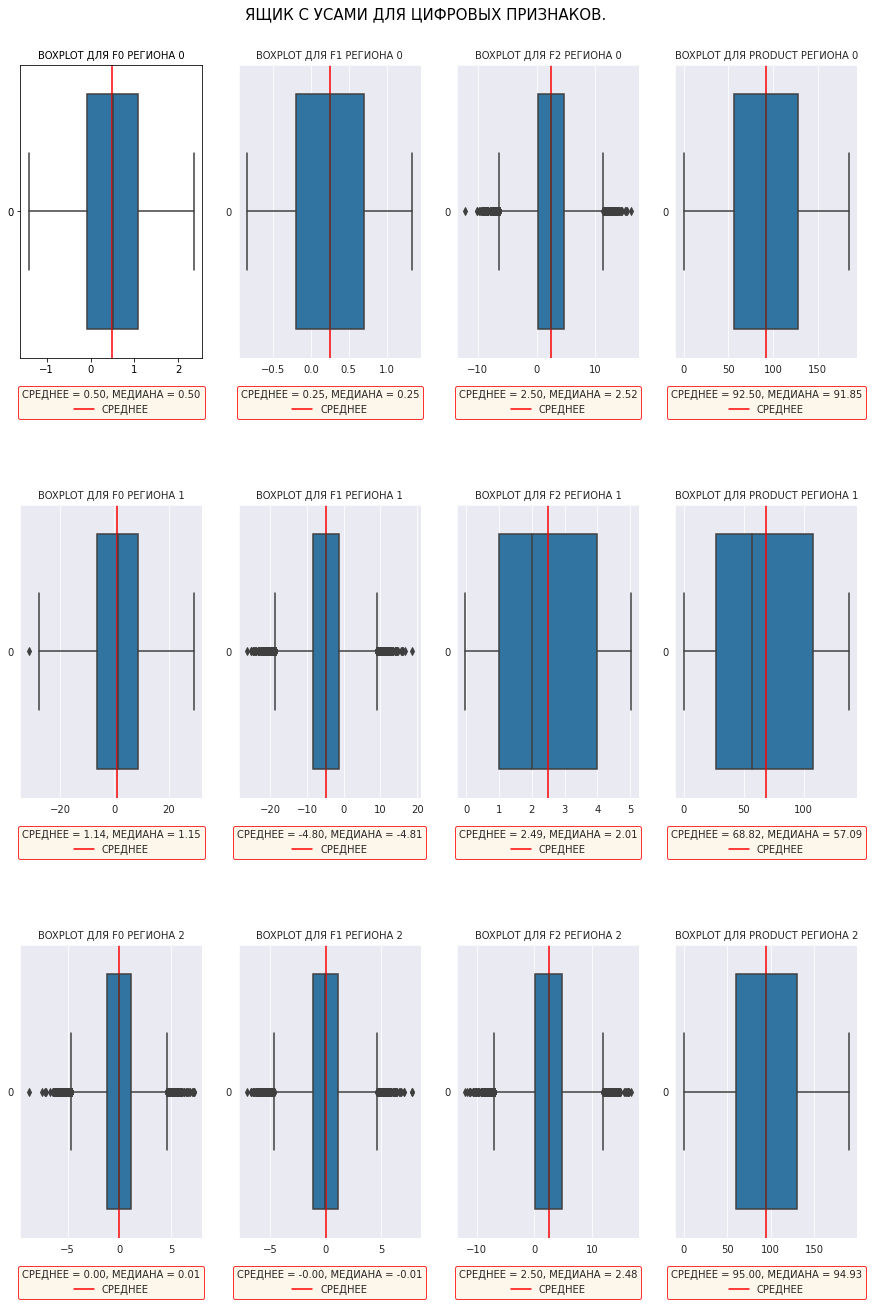

In [15]:
position = 0
num_region = None
plt.figure(figsize=[15, 20])
plt.subplots_adjust(top=0.94, wspace=0.2, hspace=0.5)
plt.suptitle('ЯЩИК С УСАМИ ДЛЯ ЦИФРОВЫХ ПРИЗНАКОВ.', fontsize=15)
for df in [data_region0, data_region1, data_region2]:
    for column_name in df.columns:
        position += 1
        plt.subplot(3, 4, position)
        sns.set_style('darkgrid')
        if 1 <= position <= 4:
            num_region = 0
        elif 4 <= position <= 8:
            num_region = 1
        elif 8 <= position <= 12:
            num_region = 2
        plt.title(f'BOXPLOT ДЛЯ {column_name.upper()} РЕГИОНА {str(num_region).upper()}', fontsize=10)
        sns.set_style('darkgrid')
        sns.boxplot(data=df[column_name], orient='h')
        plt.axvline(np.mean(df[column_name]),
                    color='r',
                    linestyle='-',
                    label='СРЕДНЕЕ')
        plt.legend(title=f'СРЕДНЕЕ = {np.mean(df[column_name]):.2f}, МЕДИАНА = {np.median(df[column_name]):.2f}', 
                   loc='center', 
                   edgecolor = 'r',
                   facecolor = 'oldlace',
                   bbox_to_anchor=(0.5, -0.15))
plt.show();

**Исходя из графиков можно сделать следующие выводы:**

 1. **Признак F2 Региона0, F0 Региона1, F2, F0  Региона 2 имеют небольшую скошенность влево( отрицательная скошенность), так как медиана незначительно больше среднего.**
 
 
 2. **Значительную разницу между средним и медианной имеют признаки F2, PRODUCT для Региона1, там медиана меньше среднего, а значит распределение имеет пооложительную скошенность. Так же легкую положительную скошенность имеют признаки product Региона 0, F1 Региона 1, F2, F1 Регинона 2.**
 
 
 3. **Для остальных значений медиана равна среднему, т.е. данные характеризуются нормальным распределением.**
 
 
 4. **В значениях признака F2 Региона 0, F1 Региона 1, F0, F1, F2 Региона 2 присутствуют выбросы.**


**Выбросы в значениях признаков могут негативно повлиять на качество модели. Оценим их количество.**

**Усы ящика простираются от первого и третьего квартиля на расстояние 1.5 межквартильного размаха( третий квартиль минус первый квартиль). В размах усов попадают нормальные значения, а за границами находятся выбросы.**

In [16]:
def get_borders(sign):
    q1 = sign.quantile(q=0.25)
    q3 = sign.quantile(q=0.75)
    iqr = q3 - q1
    min_boundary = q1 - (1.5*iqr)
    max_boundary = q3 + (1.5*iqr)
    return min_boundary, max_boundary

In [17]:
min_boundary_reg0_f2, max_boundary_reg0_f2 = get_borders(data_region0['f2'])
min_boundary_reg1_f1, max_boundary_reg1_f1 = get_borders(data_region1['f1'])
min_boundary_reg2_f0, max_boundary_reg2_f0 = get_borders(data_region2['f0'])
min_boundary_reg2_f1, max_boundary_reg2_f1 = get_borders(data_region2['f1'])
min_boundary_reg2_f2, max_boundary_reg2_f2 = get_borders(data_region2['f2'])

In [18]:
quantity_to_delete_in_reg0 = len(data_region0['f2']) - len(data_region0[(min_boundary_reg0_f2 <= data_region0['f2']) & (data_region0['f2'] <= max_boundary_reg0_f2)])
quantity_to_delete_in_reg1 = len(data_region1['f1']) - len(data_region1[(min_boundary_reg1_f1 <= data_region1['f1'])& (data_region1['f1'] <= max_boundary_reg1_f1)])
quantity_to_delete_in_reg2_f0 = len(data_region2['f0']) - len(data_region2[(min_boundary_reg2_f0 <= data_region2['f0'])& (data_region2['f0'] <= max_boundary_reg2_f0)])
quantity_to_delete_in_reg2_f1 = len(data_region2['f1']) - len(data_region2[(min_boundary_reg2_f1 <= data_region2['f1'])& (data_region2['f1'] <= max_boundary_reg2_f1)])
quantity_to_delete_in_reg2_f2 = len(data_region2['f2']) - len(data_region2[(min_boundary_reg2_f2 <= data_region2['f2'])& (data_region2['f2'] <= max_boundary_reg2_f2)])
quantity_to_delete_in_reg2 = quantity_to_delete_in_reg2_f0 + quantity_to_delete_in_reg2_f1 + quantity_to_delete_in_reg2_f2

In [19]:
print(f'\nКоличество строк на удаление в data_region0 - {quantity_to_delete_in_reg0} или %.2f' % ((quantity_to_delete_in_reg0/len(data_region0['f2']))*100), '%')
print(f'\nКоличество строк на удаление в data_region1 - {quantity_to_delete_in_reg1} или %.2f' % ((quantity_to_delete_in_reg1/len(data_region1['f1']))*100), '%')
print(f'\nКоличество строк на удаление в data_region2 - {quantity_to_delete_in_reg2} или %.2f' % ((quantity_to_delete_in_reg2/data_region1.shape[0])*100), '%')


Количество строк на удаление в data_region0 - 507 или 0.51 %

Количество строк на удаление в data_region1 - 636 или 0.64 %

Количество строк на удаление в data_region2 - 1999 или 2.00 %


**Общее количество строк содежащих аномальные значения не велико по отношению к датасету, поэтому удалим их.**

In [20]:
data_region0 = data_region0[(min_boundary_reg0_f2 <= data_region0['f2'])& (data_region0['f2'] <= max_boundary_reg0_f2)]
data_region1 = data_region1[(min_boundary_reg1_f1 <= data_region1['f1'])& (data_region1['f1'] <= max_boundary_reg1_f1)]
data_region2 = data_region2[(min_boundary_reg2_f0 <= data_region2['f0'])& (data_region2['f0'] <= max_boundary_reg2_f0)]
data_region2 = data_region2[(min_boundary_reg2_f1 <= data_region2['f1'])& (data_region2['f1'] <= max_boundary_reg2_f1)]
data_region2 = data_region2[(min_boundary_reg2_f2 <= data_region2['f2'])& (data_region2['f2'] <= max_boundary_reg2_f2)]

In [21]:
print('\nКоличество строк в data_region0 -', data_region0.shape[0])
print('\nКоличество строк в data_region1 -', data_region1.shape[0])
print('\nКоличество строк в data_region2 -', data_region2.shape[0])


Количество строк в data_region0 - 99473

Количество строк в data_region1 - 99356

Количество строк в data_region2 - 97996


### Вывод

 1. **В данных отсутствуют пропуски, формат данных соответствует типу, регистр названий корректен.**
 
 
 2. **В данных были обнаружены неянвные дубликаты. Их количество не значительно мало по отношению к общему объему каждого датасета. Было принято решение их удалить.**
 
 
 3. **Колонка id была признана не информативной и удалена.**
 
 
 4. **В некоторых признаках были обнаружены выбросы. Для улучшения дальнейшего качества обучения модели было решено удалить аномальные значения.**
 
 

## Обучение и проверка модели

**Напишем функцию, которая будет разбивать выборку да тренировочную и валидационную для каждого датасета в соотношение 75:25.**

In [22]:
def get_selections(df):
    dict_with_selections = {}
    features = df.drop('product', axis=1)
    features = features.reset_index(drop=True)
    target = df['product'].reset_index(drop=True)

    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                 target,
                                                                                 test_size=0.25,
                                                                                 random_state=12345)
    dict_with_selections['train'] = [features_train, target_train]
    dict_with_selections['valid'] = [features_valid, target_valid]
    return dict_with_selections

In [23]:
selections_for_reg0 = get_selections(data_region0)
selections_for_reg1 = get_selections(data_region1)
selections_for_reg2 = get_selections(data_region2)

In [24]:
cnt = 0
for selection in [selections_for_reg0, selections_for_reg1, selections_for_reg2]:
    print(f'\nРАЗМЕР ВЫБОРКИ ДЛЯ РЕГИОНА{str(cnt).upper()}:')
    print(f'\n ТРЕНИРОВОЧНАЯ: FEATURES - {len(selection["train"][0])}, TARGET - {len(selection["train"][1])}')
    print(f'\n ВАЛИДАЦИОННАЯ: FEATURES - {len(selection["valid"][0])}, TARGET - {len(selection["valid"][1])}')
    print('='* 100)
    cnt += 1
    


РАЗМЕР ВЫБОРКИ ДЛЯ РЕГИОНА0:

 ТРЕНИРОВОЧНАЯ: FEATURES - 74604, TARGET - 74604

 ВАЛИДАЦИОННАЯ: FEATURES - 24869, TARGET - 24869

РАЗМЕР ВЫБОРКИ ДЛЯ РЕГИОНА1:

 ТРЕНИРОВОЧНАЯ: FEATURES - 74517, TARGET - 74517

 ВАЛИДАЦИОННАЯ: FEATURES - 24839, TARGET - 24839

РАЗМЕР ВЫБОРКИ ДЛЯ РЕГИОНА2:

 ТРЕНИРОВОЧНАЯ: FEATURES - 73497, TARGET - 73497

 ВАЛИДАЦИОННАЯ: FEATURES - 24499, TARGET - 24499


**Посмотрим на показатели корреляции признаков.**

In [25]:
cnt = 0
for df in [data_region0, data_region1, data_region2]:
    print(f'КОРРЕЛЯЦИЯ ДЛЯ РЕГИОНА{str(cnt).upper()}')
    display(df.corr())
    print('='*100)
    cnt += 1

КОРРЕЛЯЦИЯ ДЛЯ РЕГИОНА0


,f0,f1,f2,product
f0,1.000000,-0.440718,-0.003382,0.143568
f1,-0.440718,1.000000,0.001161,-0.192732
f2,-0.003382,0.001161,1.000000,0.480093
product,0.143568,-0.192732,0.480093,1.000000


КОРРЕЛЯЦИЯ ДЛЯ РЕГИОНА1


,f0,f1,f2,product
f0,1.000000,0.178852,-0.001714,-0.030433
f1,0.178852,1.000000,-0.002769,-0.010187
f2,-0.001714,-0.002769,1.000000,0.999397
product,-0.030433,-0.010187,0.999397,1.000000


КОРРЕЛЯЦИЯ ДЛЯ РЕГИОНА2


,f0,f1,f2,product
f0,1.000000,0.000635,0.000512,-0.002908
f1,0.000635,1.000000,0.000739,-0.000917
f2,0.000512,0.000739,1.000000,0.441201
product,-0.002908,-0.000917,0.441201,1.000000


**Наиболее высокий показатель положительной корреляции в Регионе 1 для признака F2 и PRODUCT.**

In [26]:
print('\nКоличество уникальных значений в признаке PRODUCT РЕГИОНА 1 - ', data_region1['product'].nunique())
print('\nКоличество уникальных значений в признаке F2 РЕГИОНА 1 - ', data_region1['f2'].nunique())


Количество уникальных значений в признаке PRODUCT РЕГИОНА 1 -  12

Количество уникальных значений в признаке F2 РЕГИОНА 1 -  99356


In [27]:
data_region1['product'].value_counts()

53.906522     8423
26.953261     8414
84.038886     8379
57.085625     8340
3.179103      8288
30.132364     8266
80.859783     8262
110.992147    8251
134.766305    8243
0.000000      8173
137.945408    8169
107.813044    8148
Name: product, dtype: int64

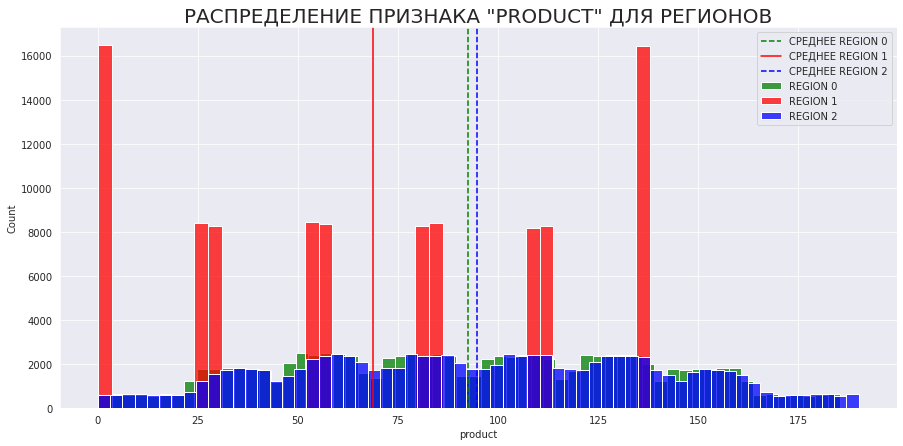

In [28]:
sns.set_style('darkgrid')
plt.figure(figsize=[15, 7])
plt.title('РАСПРЕДЕЛЕНИЕ ПРИЗНАКА "PRODUCT" ДЛЯ РЕГИОНОВ', fontsize=20)
sns.histplot(data_region0['product'], label='REGION 0', color='g', kde=False)
sns.histplot(data_region1['product'], label='REGION 1', color='r', kde=False)
sns.histplot(data_region2['product'], label='REGION 2', color='b', kde=False)
plt.axvline(np.mean(data_region0['product']),color='g', linestyle='--', label='СРЕДНЕЕ REGION 0')
plt.axvline(np.mean(data_region1['product']),color='r', linestyle='-', label='СРЕДНЕЕ REGION 1')
plt.axvline(np.mean(data_region2['product']),color='b', linestyle='--', label='СРЕДНЕЕ REGION 2')
plt.legend();

**Сильная корреляция в Регионе 1 обусловлена небольшим количеством уникальных значений в целевом признаке. Это обьясняет высокое качество модели. Преимущественно целевой признак имеет показатели выше 50. В данном регионе (Регион 1) преобладают скважины со стабильно высоким запасом нефти.**

**Для каждого региона обучим модели и сделаем прогнозы.**

In [29]:
model_for_reg0 = LinearRegression().fit(selections_for_reg0['train'][0], selections_for_reg0['train'][1])
model_for_reg1 = LinearRegression().fit(selections_for_reg1['train'][0], selections_for_reg1['train'][1])
model_for_reg2 = LinearRegression().fit(selections_for_reg2['train'][0], selections_for_reg2['train'][1])

In [30]:
dict_with_result = {}

In [31]:
predict_for_reg0 = model_for_reg0.predict(selections_for_reg0['valid'][0])
predict_for_reg1 = model_for_reg1.predict(selections_for_reg1['valid'][0])
predict_for_reg2 = model_for_reg2.predict(selections_for_reg2['valid'][0])

In [32]:
rmse_for_reg0 = (mean_squared_error(selections_for_reg0['valid'][1], predict_for_reg0))**0.5
rmse_for_reg1 = (mean_squared_error(selections_for_reg1['valid'][1], predict_for_reg1))**0.5
rmse_for_reg2 = (mean_squared_error(selections_for_reg2['valid'][1], predict_for_reg2))**0.5

In [33]:
mae_for_reg0 = mean_absolute_error(selections_for_reg0['valid'][1], predict_for_reg0)
mae_for_reg1 = mean_absolute_error(selections_for_reg1['valid'][1], predict_for_reg1)
mae_for_reg2 = mean_absolute_error(selections_for_reg2['valid'][1], predict_for_reg2)

In [34]:
mean_stock_of_oil_for_reg0 = predict_for_reg0.mean()
mean_stock_of_oil_for_reg1 = predict_for_reg1.mean()
mean_stock_of_oil_for_reg2 = predict_for_reg2.mean()

In [35]:
dict_with_result['reg0'] = [predict_for_reg0, rmse_for_reg0, mae_for_reg0, mean_stock_of_oil_for_reg0]
dict_with_result['reg1'] = [predict_for_reg1, rmse_for_reg1, mae_for_reg1, mean_stock_of_oil_for_reg1]
dict_with_result['reg2'] = [predict_for_reg2, rmse_for_reg2, mae_for_reg2, mean_stock_of_oil_for_reg2]

In [36]:
for key in dict_with_result.keys():
    print(f'\nДЛЯ {key.upper()}: RMSE - {dict_with_result[key][1]}| MAE - {dict_with_result[key][2]} | СРЕДНИЙ ЗАПАС СЫРЬЯ - {dict_with_result[key][3]:.2f}')
    print('='*100)


ДЛЯ REG0: RMSE - 37.723754923964115| MAE - 31.080609685047104 | СРЕДНИЙ ЗАПАС СЫРЬЯ - 92.59

ДЛЯ REG1: RMSE - 0.8896526017607834| MAE - 0.7162229924277624 | СРЕДНИЙ ЗАПАС СЫРЬЯ - 68.80

ДЛЯ REG2: RMSE - 40.344223192010524| MAE - 32.97569345099897 | СРЕДНИЙ ЗАПАС СЫРЬЯ - 94.61


**RMSE показывает как сильно предсказание отличается от правильного ответа. MAE показывает значение, на которое происходит отклонение. Чем меньше RMSE и МАЕ (или ближе к нулю), те лучше модель делает предсказания. В отличие от RMSE , МАЕ менее чувствительна к выбросам.**

**Наилучший показатель у модели для Региона 1. Хотя сердний запас сырья меньше, чем для остальных регионов. Для других регионов показатель RMSE намного больше нуля, а значит модели могут быть переоценнены.**

### Вывод

**Самая лучшее качество у модели для Региона 1, а не высокий средний запас нефти по сравнению с другими регионами обусловлен большим количество скважен с нулевым запасом.**

## Подготовка к расчёту прибыли

**Запишем константные значения, которые будем использовать для дальнеших вычислений.**

In [37]:
number_of_target_points = 500
number_of_best_points = 200
budget = 10*(10**9)
revenue_per_unit_of_product = 450000
treshold_for_risk = 2.5

**Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.**

In [38]:
minimum_volume_of_product = budget/(revenue_per_unit_of_product*number_of_best_points)

In [39]:
print(f'\nДостаточный объём сырья для безубыточной разработки новой скважины - {minimum_volume_of_product:.2f}')


Достаточный объём сырья для безубыточной разработки новой скважины - 111.11


**Сравним полученный объём сырья со средним запасом в каждом регионе.**

In [40]:
for key in dict_with_result.keys():
    if dict_with_result[key][3] > minimum_volume_of_product:
        print(f'\nСРЕДНИЙ ЗАПАС ({dict_with_result[key][3]:.2f}) В РЕГИОНЕ {key.upper()} БОЛЬШЕ НЕОБХОДИМОГО МИНИМУМА ОБЪЕМА СЫРЬЯ ({minimum_volume_of_product:.2f})')
        print('='*100)
    elif dict_with_result[key][3] < minimum_volume_of_product:
        print(f'\nСРЕДНИЙ ЗАПАС ({dict_with_result[key][3]:.2f}) В РЕГИОНЕ {key.upper()} МЕНЬШЕ НЕОБХОДИМОГО МИНИМУМА ОБЪЕМА СЫРЬЯ ({minimum_volume_of_product:.2f})')
        print('='*100)


СРЕДНИЙ ЗАПАС (92.59) В РЕГИОНЕ REG0 МЕНЬШЕ НЕОБХОДИМОГО МИНИМУМА ОБЪЕМА СЫРЬЯ (111.11)

СРЕДНИЙ ЗАПАС (68.80) В РЕГИОНЕ REG1 МЕНЬШЕ НЕОБХОДИМОГО МИНИМУМА ОБЪЕМА СЫРЬЯ (111.11)

СРЕДНИЙ ЗАПАС (94.61) В РЕГИОНЕ REG2 МЕНЬШЕ НЕОБХОДИМОГО МИНИМУМА ОБЪЕМА СЫРЬЯ (111.11)


### Вывод

**Регион 2 имеет самый высокий средний показатель запаса нефти по сравнению допустимым минимальным объемом сырья и с другими регионами. Но, считаю что Регион 1 наиболее предпочтительнее, так как модель прогноза имеет лучшие показатели и преимущественно в регионе преобладают скважины с высоким запасом.**

## Расчёт прибыли и рисков 

**Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели:**

 1. **Выберем скважины с максимальными значениями предсказаний (финальное кол-во точке равное 200)**
 
 
 2. **Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям ( из показаний целевого признака валидационной выборки).**
 
 
 3. **Рассчитаем прибыль для полученного объёма сырья.**

In [41]:
def profit_calculation(target, predictions, number_points):
    points_with_max_value_of_predicitions = pd.Series(predictions).sort_values(ascending=False)[:number_points]
    sum_of_targets = target.reset_index(drop=True)[points_with_max_value_of_predicitions.index].sum()
    profit = revenue_per_unit_of_product*sum_of_targets - budget
    return profit

In [42]:
estimated_profit_for_reg0 = profit_calculation(selections_for_reg0['valid'][1],
                                               predict_for_reg0,
                                               number_of_best_points)
estimated_profit_for_reg1 = profit_calculation(selections_for_reg1['valid'][1],
                                               predict_for_reg1,
                                               number_of_best_points)
estimated_profit_for_reg2 = profit_calculation(selections_for_reg2['valid'][1],
                                               predict_for_reg2,
                                               number_of_best_points)

In [43]:
cnt = 0
val = None
digit_number = None
for key in dict_with_result.keys():
    if cnt == 0:
        val = estimated_profit_for_reg0
    elif cnt == 1:
        val = estimated_profit_for_reg1
    elif cnt == 2:
        val = estimated_profit_for_reg2
    if len(str(round(val, 0))) >= 12:
        digit_number = 'млрд.'
    print(f'\nПРЕДПОЛОГАЕМАЯ ПРИБЫЛЬ В РЕГИОНЕ {key.upper()} - {val:.2f} {digit_number}')
    cnt+=1


ПРЕДПОЛОГАЕМАЯ ПРИБЫЛЬ В РЕГИОНЕ REG0 - 3267957892.71 млрд.

ПРЕДПОЛОГАЕМАЯ ПРИБЫЛЬ В РЕГИОНЕ REG1 - 2415086696.68 млрд.

ПРЕДПОЛОГАЕМАЯ ПРИБЫЛЬ В РЕГИОНЕ REG2 - 2172084103.89 млрд.


### Вывод

**Наибольшую предпологаемую валовую прибыль имеет Регон 0. Значение может быть не корректно, так как модель имеет высокий показатель RMSE.**

## Риски и прибыль для каждого региона:

In [44]:
dct_for_risk_interval_and_mean_profit = {}
state = RandomState(12345)

**Посчитаем риски и прибыль для каждого региона:**

 1. **Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.**
 
 
 2. **Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.(Убыток — это отрицательная прибыль)**

In [45]:
def get_value_of_risk_and_confidence_interval_and_profit(target, predictions):
    values = []
    for i in range(1000):
        subsample_for_target = pd.Series(target).reset_index(drop=True).sample(n = number_of_target_points, replace=True, random_state=state)
        subsample_for_predict = predictions[subsample_for_target.index]
        profit = profit_calculation(subsample_for_target, subsample_for_predict, number_of_best_points)
        values.append(profit)
    values = pd.Series(values)
    confidence_interval = [values.quantile(0.025), values.quantile(0.975)]
    mean_profit = values.mean()
    risk = (((values < 0).sum())/ len(values)) * 100
    return mean_profit, risk, confidence_interval

In [46]:
dct_for_risk_interval_and_mean_profit['region0'] = get_value_of_risk_and_confidence_interval_and_profit(selections_for_reg0['valid'][1], predict_for_reg0)
dct_for_risk_interval_and_mean_profit['region1'] = get_value_of_risk_and_confidence_interval_and_profit(selections_for_reg1['valid'][1], predict_for_reg1)
dct_for_risk_interval_and_mean_profit['region2'] = get_value_of_risk_and_confidence_interval_and_profit(selections_for_reg2['valid'][1], predict_for_reg2)

In [47]:
for key in dct_for_risk_interval_and_mean_profit.keys():
    print(f'\nДЛЯ РЕГИОНА {key.upper()}:')
    print(f'\nСРЕДНЯЯ ПРИБЫЛЬ = {dct_for_risk_interval_and_mean_profit[key][0]:.0f} | ВЕРОЯТНОСТЬ РИСКА = {dct_for_risk_interval_and_mean_profit[key][1]}%')
    print(f'\nДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ: от {dct_for_risk_interval_and_mean_profit[key][2][0]:.0f} до {dct_for_risk_interval_and_mean_profit[key][2][1]:.0f}')
    print('='*100)


ДЛЯ РЕГИОНА REGION0:

СРЕДНЯЯ ПРИБЫЛЬ = 378298088 | ВЕРОЯТНОСТЬ РИСКА = 7.1%

ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ: от -106768256 до 852188553

ДЛЯ РЕГИОНА REGION1:

СРЕДНЯЯ ПРИБЫЛЬ = 440575074 | ВЕРОЯТНОСТЬ РИСКА = 1.5%

ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ: от 54467744 до 809780533

ДЛЯ РЕГИОНА REGION2:

СРЕДНЯЯ ПРИБЫЛЬ = 302896138 | ВЕРОЯТНОСТЬ РИСКА = 12.6%

ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ: от -240266463 до 833640873


**Выберем регион, где риск убытков меньше обозначенного порога (2.5%) по условию задачи.**

In [48]:
list_for_name_region = []
list_for_value_region = []
for key in dct_for_risk_interval_and_mean_profit.keys():
    if dct_for_risk_interval_and_mean_profit[key][1] < treshold_for_risk:
        list_for_name_region.append(key)
for name in list_for_name_region:
    list_for_value_region.append(dct_for_risk_interval_and_mean_profit[key][0])
max_mean = max(list_for_value_region)
index = list_for_value_region.index(max_mean)
winner = list_for_name_region[index]
print(f'\nПОДХОДЯЩИЙ ДЛЯ РАЗРАБОТКИ РЕГИОН - {winner.upper()}')
print(f'\nСРЕДНЯЯ ПРИБЫЛЬ = {dct_for_risk_interval_and_mean_profit[winner][0]:.0f} | ВЕРОЯТНОСТЬ РИСКА = {dct_for_risk_interval_and_mean_profit[winner][1]}%')


ПОДХОДЯЩИЙ ДЛЯ РАЗРАБОТКИ РЕГИОН - REGION1

СРЕДНЯЯ ПРИБЫЛЬ = 440575074 | ВЕРОЯТНОСТЬ РИСКА = 1.5%


### Вывод

**Выбранный регион имеет самое высокое значение прибыли и минимальную вероятность риска.**

# Вывод

**Был выбран Регион 1, так как он имеет самое большое значение прибыли и минимальную вероятность риска. Кроме того, у модели для предсказания для данного региона показатель RMSE и MAE минимален, а исходя из графиков в регионе преимущественно преобладают скважины с высоким запасом нефти. Преиод эксплуатации таких скважин будет выше, чем у скважин в других регионах, и операционные затраты на разварачивание/обратную сборку оборудования и время доставки к месту разработки будут меньше.**